In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# this is where the sacrebleu is modified
sacrebleu_path = '/nas/material02/users/tg/projects/beter-bleu/rebleu'
if sacrebleu_path not in sys.path:
    print(f'adding to sys.path: {sacrebleu_path}')
    sys.path.insert(0, sacrebleu_path)

os.environ['PYTHONPATH'] = sacrebleu_path
from sacrebleu import corpus_bleu
from sacrebleu.metrics import METRICS
print("\n".join(METRICS.keys()))

adding to sys.path: /nas/material02/users/tg/projects/beter-bleu/rebleu
bleu
chrf
ter
rebleu
rechrf
rebleu2
macrobleu
microbleu
macrof
microf
macrochrf
microchrf


In [2]:
!python -m sacrebleu -V

__main__.py 1.4.13


In [3]:
%cd /nas/home/tg/work2/projects/beter-bleu
# cd to where the 'wmt' dir is available

/nas/material02/users/tg/projects/beter-bleu


# WMT System-Outputs, Refrences and Human Assessments

See setup.md file in this dir to get these files
Here they are!

In [4]:
! ls wmt
! ls wmt/wmt-submissions
! ls wmt/wmt-sys-scores | head
! head wmt/wmt-sys-scores/DA-newstest2017-csen-sys-nohy-scores.csv | head

errors	metrics-task  submissions  wmt-submissions  wmt-sys-scores
references  sources  system-outputs
DA-newstest2017-csen-sys-nohy-scores.csv
DA-newstest2017-deen-sys-nohy-scores.csv
DA-newstest2017-encs-sys-nohy-scores.csv
DA-newstest2017-ende-sys-nohy-scores.csv
DA-newstest2017-enfi-sys-nohy-scores.csv
DA-newstest2017-enlv-sys-nohy-scores.csv
DA-newstest2017-enru-sys-nohy-scores.csv
DA-newstest2017-entr-sys-nohy-scores.csv
DA-newstest2017-enzh-sys-nohy-scores.csv
DA-newstest2017-fien-sys-nohy-scores.csv
LP SYSTEM HUMAN AutoDA BEER BLEU Blend CDER CharacTer MEANT_2_DOT_0 MEANT_2_DOT_0_DASH_nosrl NIST PER TER TreeAggreg UHH_TSKM WER bleu2vec_sep chrF_PLUS__PLUS_ ngram2vec
cs-en uedin-nmt.4955 0.181 0.09712974307144343 0.5899283664595466 0.3248 0.05576801522202579 0.5253 -0.543242447285 0.7224391638935108 0.7525316692231697 8.0391 0.6385 0.4749 0.5455556250649959 0.5495985694415557 0.4430 0.460692 54.9459 0.40378
cs-en online-B.0 0.068 0.12099793191360753 0.5740948516794925 0.2877 0.00

# Step1: Parse System Level Scores from WMT

In [5]:
import collections as coll
from pathlib import Path
from dataclasses import dataclass, field

In [6]:
scores_dir = Path('wmt/wmt-sys-scores')
WMTs = ['2019', '2018', '2017']


score_paths = {}
for year in WMTs:
    score_paths[year] = langs = {}
    lang_pairs = list(scores_dir.glob(f'DA-newstest{year}-*-scores.csv'))
    for pair_file in lang_pairs:
        # DA-newstest20yy-xxyy-sys-nohy-scores.csv
        parts = pair_file.name.split('-')
        assert len(parts) == 6
        pair = parts[2]
        langs[pair] = pair_file
print([(y, list(d.keys())) for y, d in score_paths.items()])

[('2019', ['decs', 'deen', 'defr', 'encs', 'ende', 'enfi', 'engu', 'enkk', 'enlt', 'enru', 'enzh', 'fien', 'frde', 'guen', 'kken', 'lten', 'ruen', 'zhen']), ('2018', ['csen', 'deen', 'encs', 'ende', 'enet', 'enfi', 'enru', 'entr', 'enzh', 'eten', 'fien', 'ruen', 'tren', 'zhen']), ('2017', ['csen', 'deen', 'encs', 'ende', 'enfi', 'enlv', 'enru', 'entr', 'enzh', 'fien', 'lven', 'ruen', 'tren', 'zhen'])]


# Step 2: Load Sys-Out and Ref

Create a schema and load all to mem

In [6]:
from typing import List, Dict, Union
import logging as log
log.basicConfig(level=log.INFO)

@dataclass(repr=False)
class System:
    camp: str 
    lang: str
    name: str 
    out: Union[Path, List[str]]
    ref: Union[Path, List[str]]
    scores: Dict
    #parent: 'TransTask'        
    # exclude out and ref from repr, otherwise it is too much
    

@dataclass
class TransTask:
    camp: str
    name: str
    ref: Union[Path, List[str]] = field(default_factory=list, repr=False)
    systs: Dict[str, System] = field(default_factory=dict, repr=True)
    #parent: 'Campaign'        

@dataclass
class Campaign:
    name: str
    #root: Path
    langs: List
    tasks: Dict[str, TransTask]

def read_lines(path: Path):
    with path.open('r', encoding='utf-8', errors='ignore') as rdr:
        return list(line.strip() for line in rdr)

    
def read_sys_scores(path):
    lines = read_lines(path)
    if not lines:
        return {}
    recs = [line.split() for line in lines]
    head = recs[0]
    recs = recs[1:]
    assert all(len(r) == len(head) for r in recs)
    # all recs have same language pair at r[0], that we can skip
    assert all(r[0] == recs[0][0] for r in recs)

    # r[1] has system name
    # {sysname1: {metric1:val1, metric2: val2, ...}, sysname2: ... }
    data = {r[1]: dict(zip(head[2:], [float(x) for x in r[2:]])) for r in recs}
    return data

In [7]:
submissions_dir = Path('wmt/wmt-submissions/')

camps = {}
for year in WMTs:
    name=f'wmt{year}'
    test = f'newstest{year}'
    #txt_dir = wmt_dir / f'submissions/{name}-submitted-data/txt/'
    camp = Campaign(name=year, tasks={}, langs=list(score_paths[year].keys())) # root=None
    camps[name] = camp
    for pair in camp.langs:
        assert len(pair) == 4  # 4 chars sstt
        src = pair[:2]
        tgt = pair[-2:]
        ref = submissions_dir / 'references' / f'{test}-{pair}-ref.{tgt}'
        assert ref.exists(), f'{ref} not found'
        ref = read_lines(ref)

        task = TransTask(name=pair, camp=camp.name, systs={}, ref=ref)
        camp.tasks[pair] = task
        score_path = score_paths[year][pair]
        print(pair, src, tgt, score_path)
        systems = read_sys_scores(score_path)
        if not systems:
            log.warning(f"Empty: {score_path}")
            continue
        for syst_name, syst_scores in systems.items():
            out_path = submissions_dir / f'system-outputs/{test}/{src}-{tgt}/{test}.{syst_name}.{src}-{tgt}'
            if not out_path.exists():  # relocate file; looks like they did some mess; try mapping using sys_id integer
                syst_id = int(syst_name.split('.')[-1])
                remap = list(out_path.parent.glob(f'*.{syst_id}.{src}-{tgt}'))
                if len(remap) == 1:
                    out_path = remap[0]
                    log.warning(f"fixing name: {syst_name} -> {out_path.name}")
                else:
                    log.warning(f'{out_path} not found. Skipping')
                    continue
            out = read_lines(out_path)
            syst = System(name=syst_name, lang=task.name, camp=camp.name, out=out, ref=ref,
                               scores=syst_scores)
            task.systs[syst_name] = syst

decs de cs wmt/wmt-sys-scores/DA-newstest2019-decs-sys-nohy-scores.csv
deen de en wmt/wmt-sys-scores/DA-newstest2019-deen-sys-nohy-scores.csv
defr de fr wmt/wmt-sys-scores/DA-newstest2019-defr-sys-nohy-scores.csv
encs en cs wmt/wmt-sys-scores/DA-newstest2019-encs-sys-nohy-scores.csv
ende en de wmt/wmt-sys-scores/DA-newstest2019-ende-sys-nohy-scores.csv
enfi en fi wmt/wmt-sys-scores/DA-newstest2019-enfi-sys-nohy-scores.csv
engu en gu wmt/wmt-sys-scores/DA-newstest2019-engu-sys-nohy-scores.csv
enkk en kk wmt/wmt-sys-scores/DA-newstest2019-enkk-sys-nohy-scores.csv
enlt en lt wmt/wmt-sys-scores/DA-newstest2019-enlt-sys-nohy-scores.csv
enru en ru wmt/wmt-sys-scores/DA-newstest2019-enru-sys-nohy-scores.csv
enzh en zh wmt/wmt-sys-scores/DA-newstest2019-enzh-sys-nohy-scores.csv
fien fi en wmt/wmt-sys-scores/DA-newstest2019-fien-sys-nohy-scores.csv
frde fr de wmt/wmt-sys-scores/DA-newstest2019-frde-sys-nohy-scores.csv
guen gu en wmt/wmt-sys-scores/DA-newstest2019-guen-sys-nohy-scores.csv
kken k

encs en cs wmt/wmt-sys-scores/DA-newstest2017-encs-sys-nohy-scores.csv
ende en de wmt/wmt-sys-scores/DA-newstest2017-ende-sys-nohy-scores.csv
enfi en fi wmt/wmt-sys-scores/DA-newstest2017-enfi-sys-nohy-scores.csv


enlv en lv wmt/wmt-sys-scores/DA-newstest2017-enlv-sys-nohy-scores.csv
enru en ru wmt/wmt-sys-scores/DA-newstest2017-enru-sys-nohy-scores.csv
entr en tr wmt/wmt-sys-scores/DA-newstest2017-entr-sys-nohy-scores.csv
enzh en zh wmt/wmt-sys-scores/DA-newstest2017-enzh-sys-nohy-scores.csv
fien fi en wmt/wmt-sys-scores/DA-newstest2017-fien-sys-nohy-scores.csv
lven lv en wmt/wmt-sys-scores/DA-newstest2017-lven-sys-nohy-scores.csv


ruen ru en wmt/wmt-sys-scores/DA-newstest2017-ruen-sys-nohy-scores.csv
tren tr en wmt/wmt-sys-scores/DA-newstest2017-tren-sys-nohy-scores.csv
zhen zh en wmt/wmt-sys-scores/DA-newstest2017-zhen-sys-nohy-scores.csv


# BLEU score


Tokenize all ahead of time and keep them in memory. 
this is efficient than tokenizing refs multiple times, once per each system.

In [28]:
from sacrebleu.tokenizers import TOKENIZERS

def tokenize(lang, sents):
    assert isinstance(sents, list) and isinstance(sents[0], str)
    tokr = TOKENIZERS['13a']()

    if lang == 'zh':
        tokr = TOKENIZERS['zh']()
    return [tokr(sent) for sent in sents]
 

In [8]:
for camp in camps.values():
    for task in camp.tasks.values():
        print(f"{camp.name}\t{task.name}\t{len(task.ref)}\t{len(task.systs)}")
        lang = task.name[-2:]
        task.ref_tok = tokenize(lang, task.ref)
        
        for syst in task.systs.values():
            assert syst.ref is task.ref # same object; no duplicates
            assert len(syst.ref) == len(syst.out)
            syst.out_tok = tokenize(lang, syst.out)
            syst.ref_tok = task.ref_tok

2019	decs	1997	11
2019	deen	2000	16
2019	defr	1701	11
2019	encs	1997	11
2019	ende	1997	22
2019	enfi	1997	12
2019	engu	998	11
2019	enkk	998	11
2019	enlt	998	12
2019	enru	1997	12
2019	enzh	1997	12
2019	fien	1996	12
2019	frde	1701	10
2019	guen	1016	11
2019	kken	1000	11
2019	lten	1000	11
2019	ruen	2000	14
2019	zhen	2000	15
2018	csen	2983	5
2018	deen	2998	16
2018	encs	2983	5
2018	ende	2998	16
2018	enet	2000	14
2018	enfi	3000	12
2018	enru	3000	9
2018	entr	3000	8
2018	enzh	3981	14
2018	eten	2000	14
2018	fien	3000	9
2018	ruen	3000	8
2018	tren	3000	5
2018	zhen	3981	14
2017	csen	3005	4
2017	deen	3004	11
2017	encs	3005	14
2017	ende	3004	16
2017	enfi	3002	12
2017	enlv	2001	0
2017	enru	3001	9
2017	entr	3007	8
2017	enzh	2001	11
2017	fien	3002	6
2017	lven	2001	9
2017	ruen	3001	9
2017	tren	3007	10
2017	zhen	2001	15


In [9]:
list(list(camps.values())[0].tasks.values())[0]

TransTask(camp='2019', name='decs', systs={'lmu-unsup-nmt-de-cs.6845': <__main__.System object at 0x7f5968c73c88>, 'Unsupervised.de-cs.6935': <__main__.System object at 0x7f5968c73fd0>, 'NICT.6938': <__main__.System object at 0x7f5968c73c18>, 'online-B.0': <__main__.System object at 0x7f5968c1f080>, 'Unsupervised.de-cs.6929': <__main__.System object at 0x7f5968c1f160>, 'online-A.0': <__main__.System object at 0x7f5968c1f128>, 'CUNI-Unsupervised-NER-post.6934': <__main__.System object at 0x7f5968c1f1d0>, 'online-Y.0': <__main__.System object at 0x7f5968c1f198>, 'online-G.0': <__main__.System object at 0x7f5968c1f2b0>, 'NEU_KingSoft.6766': <__main__.System object at 0x7f5968c1f358>, 'CAiRE.6949': <__main__.System object at 0x7f597113ada0>})

In [10]:
# store as pickles
import pickle

file_name = 'camps.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(camps, f)

In [12]:
! python -m sacrebleu -V

__main__.py 1.4.13


Verify that python API with ahead-of-time tokenization yields same scores as CLI which downloads refs itself and tokenizes on-the-fly.

In [13]:
%%bash
for lang in en-ru en-zh; do
    ls wmt/wmt-submissions/system-outputs/newstest2019/$lang/* \
    | head -2 | while read i; do
        echo -n "$lang $(basename $i) "
        cat $i| python -m sacrebleu -m bleu -t wmt19 -l $lang -b
    done
done

en-ru newstest2019.Facebook_FAIR.6724.en-ru 36.3
en-ru newstest2019.NEU.6773.en-ru 34.0
en-zh newstest2019.Baidu-system.6932.en-zh 42.4
en-zh newstest2019.BTRANS.6821.en-zh 38.3


In [11]:
from argparse import Namespace
bleu_args = Namespace(force=True, smooth_method='exp',
                smooth_value=None, lc=False, tokenize='none')
bleu = METRICS['bleu'](args=bleu_args)
bleu.signature

case.mixed+numrefs.?+smooth.exp+tok.none+version.1.4.13

In [12]:
select = [['enru', 'Facebook_FAIR.6724', 'NEU.6773'],
         ['enzh', 'Baidu-system.6932', 'BTRANS.6821']]
for lang, *systs in select:
    for syst_name in systs:
        syst = camps['wmt2019'].tasks[lang].systs[syst_name]
        #score =  corpus_bleu(syst.out_tok, [syst.ref_tok], tokenize='none', lowercase=False)
        score = bleu.corpus_score(sys_stream=syst.out_tok, ref_streams=[syst.ref_tok])
        print(lang, syst_name,  f'\t\tComputed {score.score:.1f}; metrics package: {syst.scores["sacreBLEU-BLEU"]}')

enru Facebook_FAIR.6724 		Computed 36.3; metrics package: 0.3719
enru NEU.6773 		Computed 34.0; metrics package: 0.3462
enzh Baidu-system.6932 		Computed 42.4; metrics package: 0.197
enzh BTRANS.6821 		Computed 38.3; metrics package: 0.0858


In [44]:

#help(b.corpus_score)
bleu.corpus_score(sys_stream=['the quick brown fox'], ref_streams=[['the quick box brown jump']]).score

27.534765745159184

> NOTE: The scores we compute
via python API matches with CLI; but not with metrics package.
This could be result of sacreBLEU version mismatch or some (non-default) settings they enabled.

Also, metrics package messed up tokenization on Chinese 😂; they have scores of 19 and 8, but clearly the scores could be better as 42 and 38, with chinese tokenizer.

In [64]:
%%bash

sys=wmt/wmt-submissions/system-outputs/newstest2019/en-zh/newstest2019.Baidu-system.6932.en-zh
cat $sys | python -m sacrebleu -t wmt19 -l en-zh -m bleu chrf macrobleu microbleu rebleu2 macrochrf microchrf 

BLEU+case.mixed+lang.en-zh+numrefs.1+smooth.exp+test.wmt19+tok.zh+version.1.4.13 = 42.4 70.4/49.4/36.3/27.7 (BP = 0.979 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
chrF2+lang.en-zh+numchars.6+space.false+test.wmt19+version.1.4.13 = 0.41
MacroBLEU[β=1]+average.macro+case.mixed+lang.en-zh+ngram.4+numrefs.1+smooth.add-k.1+test.wmt19+tok.zh+version.1.4.13 50.1 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MicroBLEU[β=1]+average.micro+case.mixed+lang.en-zh+ngram.4+numrefs.1+smooth.add-k.1+test.wmt19+tok.zh+version.1.4.13 60.4 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
ReBLEU2[f1]+average.micro+case.mixed+lang.en-zh+ngram.4+numrefs.1+smooth.add-k.1+test.wmt19+tok.zh+version.1.4.13 42.3 41.4 7e+01/5e+01/4e+01/3e+01 ( ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MacroCHRF[β=2]+average.macro+lang.en-zh+numchars.6+smooth.add-k.1+space.false+test.wmt19+version.1.4.13 = 21.3
MicroCHRF[β=2]+average.micro+lang.en-zh+numchars.6+smooth.add-k.1+space.false+test.wmt19

In [20]:
bleu = METRICS['bleu'](args=Namespace(force=True, smooth_method='exp', smooth_value=None, lc=False, tokenize='none'))
chrf1 = METRICS['chrf'](args=Namespace(chrf_whitespace=False, chrf_order=6, chrf_beta=1))
chrf2 = METRICS['chrf'](args=Namespace(chrf_whitespace=False, chrf_order=6, chrf_beta=2))
chrf3 = METRICS['chrf'](args=Namespace(chrf_whitespace=False, chrf_order=6, chrf_beta=3))

my_f_args = dict(force=True, smooth_method='add-k', smooth_value=1, lc=False, tokenize='none')
macro_f1 = METRICS['macrof'](args=Namespace(**my_f_args, rebleu_beta=1))
macro_f2 = METRICS['macrof'](args=Namespace(**my_f_args, rebleu_beta=2))
macro_f3 = METRICS['macrof'](args=Namespace(**my_f_args, rebleu_beta=3))

micro_f1 = METRICS['microf'](args=Namespace(**my_f_args, rebleu_beta=1))
micro_f2 = METRICS['microf'](args=Namespace(**my_f_args, rebleu_beta=2))
micro_f3 = METRICS['microf'](args=Namespace(**my_f_args, rebleu_beta=3))

micro_f1_log = METRICS['rebleu'](args=Namespace(**my_f_args, rebleu_beta=1, rebleu_order=1, average='micro_log'), name='MicroFLog')
micro_f2_log = METRICS['rebleu'](args=Namespace(**my_f_args, rebleu_beta=2, rebleu_order=1, average='micro_log'), name='MicroFLog')
micro_f3_log = METRICS['rebleu'](args=Namespace(**my_f_args, rebleu_beta=3, rebleu_order=1, average='micro_log'), name='MicroFLog')
micro_f1_sqrt = METRICS['rebleu'](args=Namespace(**my_f_args, rebleu_beta=1, rebleu_order=1, average='micro_sqrt'), name='MicroFSqrt')
micro_f2_sqrt = METRICS['rebleu'](args=Namespace(**my_f_args, rebleu_beta=2, rebleu_order=1, average='micro_sqrt'), name='MicroFSqrt')
micro_f3_sqrt = METRICS['rebleu'](args=Namespace(**my_f_args, rebleu_beta=3, rebleu_order=1, average='micro_sqrt'), name='MicroFSqrt')



my_bleu_args = dict(**my_f_args, rebleu_beta=1, rebleu_order=4)
macro_bleu = METRICS['macrobleu'](args=Namespace(**my_bleu_args))
micro_bleu = METRICS['microbleu'](args=Namespace(**my_bleu_args))

micro_bleu_log = METRICS['rebleu'](args=Namespace(average='micro_log', **my_bleu_args), name='MicroLogBLEU')
micro_bleu_sqrt = METRICS['rebleu'](args=Namespace(average='micro_sqrt', **my_bleu_args), name='MicroSqrtBLEU')

macro_bleu2 = METRICS['rebleu2'](args=Namespace(average='macro', **my_bleu_args), name='MacroBLEU2')
micro_bleu2 = METRICS['rebleu2'](args=Namespace(average='micro', **my_bleu_args), name='MicroBLEU2')
micro_bleu2_log = METRICS['rebleu2'](args=Namespace(average='micro_log', **my_bleu_args), name='MicroLogBLEU2')
micro_bleu2_sqrt = METRICS['rebleu2'](args=Namespace(average='micro_sqrt', **my_bleu_args), name='MicroSqrtBLEU2')

my_chrf_args = dict(chrf_whitespace=False, chrf_order=6, smooth_value=1, smooth_method='add-k')
macro_chrf1 = METRICS['macrochrf'](args=Namespace(**my_chrf_args, chrf_beta=1))
macro_chrf3 = METRICS['macrochrf'](args=Namespace(**my_chrf_args, chrf_beta=3))
micro_chrf1 = METRICS['microchrf'](args=Namespace(**my_chrf_args, chrf_beta=1))
micro_chrf3 = METRICS['microchrf'](args=Namespace(**my_chrf_args, chrf_beta=3))

micro_chrf1_log = METRICS['rechrf'](args=Namespace(**my_chrf_args, chrf_beta=1, average='micro_log'), name='MicroLogCHRF')
micro_chrf3_log = METRICS['rechrf'](args=Namespace(**my_chrf_args, chrf_beta=3, average='micro_log'), name='MicroLogCHRF')

micro_chrf1_sqrt = METRICS['rechrf'](args=Namespace(**my_chrf_args, chrf_beta=1, average='micro_sqrt'), name='MicroSqrtCHRF')
micro_chrf3_sqrt = METRICS['rechrf'](args=Namespace(**my_chrf_args, chrf_beta=3, average='micro_sqrt'), name='MicroSqrtCHRF')


tok_measures = [bleu, macro_f1, macro_f2, macro_f3, micro_f1, micro_f2, micro_f3, micro_f1_log, micro_f2_log, micro_f3_log, micro_f1_sqrt, micro_f2_sqrt, micro_f3_sqrt,
                macro_bleu, micro_bleu, micro_bleu_log, micro_bleu_sqrt, macro_bleu2, micro_bleu2, micro_bleu2_log, micro_bleu2_sqrt]
char_measures = [chrf1, chrf2, chrf3, macro_chrf1,macro_chrf3, micro_chrf1, micro_chrf3, micro_chrf1_log, micro_chrf3_log, micro_chrf1_sqrt, micro_chrf3_sqrt]

In [21]:

syst = camps['wmt2019'].tasks['enzh'].systs['Baidu-system.6932']
for is_tok, measures in [(True, tok_measures), (False, char_measures)]:
    for m in measures:
        sys_stream = syst.out_tok if is_tok else syst.out
        ref_stream = syst.ref_tok if is_tok else syst.ref 
        score = m.corpus_score(sys_stream=sys_stream, ref_streams=[ref_stream])
        line = score.format(signature=m.signature)
        name = line.split('+')[0]
        print(line.split('+')[0]+ '\t' + line[len(name)+1:])

BLEU	case.mixed+numrefs.?+smooth.exp+tok.none+version.1.4.13 = 42.37 70.4/49.4/36.3/27.7 (BP = 0.979 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MacroF[β=1]	average.macro+case.mixed+ngram.1+numrefs.?+smooth.add-k.1+tok.none+version.1.4.13 57.33 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MacroF[β=2]	average.macro+case.mixed+ngram.1+numrefs.?+smooth.add-k.1+tok.none+version.1.4.13 57.51 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MacroF[β=3]	average.macro+case.mixed+ngram.1+numrefs.?+smooth.add-k.1+tok.none+version.1.4.13 57.82 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MicroF[β=1]	average.micro+case.mixed+ngram.1+numrefs.?+smooth.add-k.1+tok.none+version.1.4.13 68.71 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MicroF[β=2]	average.micro+case.mixed+ngram.1+numrefs.?+smooth.add-k.1+tok.none+version.1.4.13 68.32 ( BP = 1.000 ratio = 0.980 hyp_len = 79019 ref_len = 80666)
MicroF[β=3]	average.micro+case.mixed+ngram.1+numrefs

In [8]:
from tqdm import tqdm
import multiprocessing as mp
import os
import csv
import pickle
cpu_count = mp.cpu_count()
if 'SLURM_CPUS_ON_NODE' in os.environ:
    cpu_count = int(os.environ['SLURM_CPUS_ON_NODE'])
print('cpus', cpu_count)

cpus 20


In [ ]:
def read_args():
    #for langs in gold_sys_scores.keys():
    for camp in camps.values():
        for task in camp.tasks.values():
            for syst in task.systs.values():
                yield syst
systs = list(read_args())

def scoring_job(syst):
    res = {}
    signi = 5
    for is_tok, measures in [(True, tok_measures), (False, char_measures)]:
        for m in measures:
            sys_stream = syst.out_tok if is_tok else syst.out
            ref_stream = syst.ref_tok if is_tok else syst.ref 
            score = m.corpus_score(sys_stream=sys_stream, ref_streams=[ref_stream])
            line = score.format(signature=m.signature)
            # adding an underscore to distinguish from the scores from metric package; e.g. BLEU exists at both places
            name = '_' + line.split('+')[0]
            res[name] = round(score.score, signi)
            if hasattr(score, 'score2'):
                res[name + '_score2'] = round(score.score2, signi)
    sys_id = syst.camp, syst.lang, syst.name
    return sys_id, res


def write_scores(systs, path):
    all_keys = set()
    for syst in systs:
        all_keys.update(syst.scores.keys())
    fieldnames = ['camp', 'lang', 'syst'] + list(all_keys)
    with open(path, 'w', encoding='utf8', newline='') as wrt:
        dwrt = csv.DictWriter(wrt, fieldnames=fieldnames, delimiter='\t')
        dwrt.writeheader()
        for syst in systs:
            row = dict(camp=syst.camp, lang=syst.lang, syst=syst.name)
            row.update(syst.scores)
            dwrt.writerow(row)

with mp.Pool(cpu_count) as pool:
    #systs = list(read_args())
 
    for res in tqdm(pool.imap(scoring_job, systs), total=len(systs)):
    #for res in pool.map(scoring_job, systs):
        (year, lang_name, syst_name), scores = res
        wmt_name = f'wmt{year}'
        # scores updated back on the object of main process; all forks have copies that we dont need
        camps[wmt_name].tasks[lang_name].systs[syst_name].scores.update(scores)

scores_file = 'all-scores-02.tsv'
write_scores(systs, scores_file)

print("Done")

 72%|███████▏  | 368/508 [1:14:45<1:40:00, 42.86s/it]

In [28]:
#write_scores(systs, scores_file)

In [29]:
file_name = 'camps-scored.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(camps, f)

In [ ]:
# Fix ENZH 2019

In [11]:
# reload pkl
file_name = 'camps-scored.pkl'
with open(file_name, 'rb') as f:
    camps = pickle.load(f)

In [26]:
ref_cln = Path('wmt/wmt-submissions/references/newstest2019-enzh-ref.zh.cln')
ref_cln_lines= read_lines(ref_cln)
#dir(camps['wmt2019'].tasks['enzh'])


In [29]:
tokenize('zh', ref_cln_lines[:10])

['威 尔 士 AM 担 心 ” 像 蠢 蛋 “',
 '有 人 提 议 ， AM 应 该 将 头 衔 改 为 MWP （ 威 尔 士 议 会 议 员 ） ， 这 让 好 多 AM 大 为 震 惊 。',
 '之 所 以 有 人 这 样 提 议 ， 是 因 为 计 划 要 将 议 会 名 称 改 为 “ 威 尔 士 议 会 ” 。',
 '政 治 界 的 AM 担 心 这 会 惹 人 嘲 笑 。',
 '一 名 工 党 AM 表 示 ， 工 党 成 员 担 心 “ 这 个 名 称 与 Twp 和 Pwp 押 韵 ” 。',
 '（ 非 威 尔 士 读 者 须 知 ： 在 威 尔 士 语 中 ， twp 的 意 思 为 “ 愚 蠢 ” ， pwp 意 思 为 “ 大 便 ” 。',
 '一 名 民 族 党 AM 表 示 ， 整 个 民 族 党 人 员 都 “ 不 满 意 “ ， 建 议 换 成 其 他 名 称 。',
 '一 名 威 尔 士 保 守 党 人 表 示 ， 保 守 党 对 这 次 更 名 “ 持 开 放 态 度 ” ， 但 指 出 ， 发 音 上 很 容 易 将 MWP 发 成 Muppet 的 音 。',
 '在 该 语 境 下 ， 威 尔 士 字 母 w 的 发 音 类 似 于 约 克 郡 英 语 字 母 u 的 发 音 。',
 '议 会 委 员 会 目 前 正 在 对 名 称 变 更 起 草 法 律 ， 他 说 ： “ 关 于 委 员 会 成 员 最 终 决 定 选 择 用 什 么 名 字 ， 这 是 他 们 自 己 的 事 情 。 ”']

--- 

# Correlations with Human Judgements

In [5]:
import pandas as pd
scores_file = 'all-scores-02.tsv'
scores = pd.read_csv(scores_file, header=0, sep='\t')
scores

camp  lang                      syst  _MicroLogBLEU[β=1]  PReP  \
0    2019  decs  lmu-unsup-nmt-de-cs.6845            20.79240   NaN   
1    2019  decs   Unsupervised.de-cs.6935            19.23059   NaN   
2    2019  decs                 NICT.6938            24.55838   NaN   
3    2019  decs                online-B.0            24.88483   NaN   
4    2019  decs   Unsupervised.de-cs.6929            20.42877   NaN   
..    ...   ...                       ...                 ...   ...   
503  2017  zhen     SogouKnowing-nmt.5171            36.40622   NaN   
504  2017  zhen            uedin-nmt.5112            35.72108   NaN   
505  2017  zhen              UU-HNMT.5162            27.61838   NaN   
506  2017  zhen            PROMT-SMT.5125            30.64292   NaN   
507  2017  zhen          CASICT-cons.5144            32.41652   NaN   

     hLEPORa_baseline  _MicroSqrtCHRF[β=3]   _chrF1  _MacroF[β=3]  \
0            0.508274              0.29483  0.44167      18.88676   
1            0.496409              0.27423  0.42008      17.65836   
2            0.554033              0.33660  0.48143      23.15588   
3            0.543159              0.33482  0.48882      23.75348   
4            0.515771              0.28692  0.43136      18.79233   
..                ...                  ...      ...           ...   
503               NaN              0.40642  0.55133      35.93778   
504               NaN              0.39292  0.54210      34.35087   
505               NaN              0.29727  0.47080      24.14920   
506               NaN              0.32313  0.48637      30.04762   
507               NaN              0.33351  0.51189      30.18665   

     bleu2vec_sep  ...  meteor++  _MicroFLog[β=3]  _MacroBLEU[β=1]   _chrF2  \
0             NaN  ...       NaN         24.23822         15.33361  0.43657   
1             NaN  ...       NaN         22.69366         14.14793  0.41577   
2             NaN  ...       NaN         28.86117         18.79174  0.47821   
3             NaN  ...       NaN         29.28038         19.21149  0.48091   
4             NaN  ...       NaN         24.04083         15.13184  0.42679   
..            ...  ...       ...              ...              ...      ...   
503      0.407863  ...       NaN         42.01393         29.84787  0.55022   
504      0.404387  ...       NaN         40.53320         28.86346  0.53540   
505      0.288322  ...       NaN         29.33480         21.16154  0.45249   
506      0.310175  ...       NaN         36.07609         24.04309  0.48367   
507      0.366690  ...       NaN         35.88481         25.77723  0.49743   

     _MicroSqrtBLEU2[f1]  _MicroLogBLEU2[f1]  CharacTer  USFD  \
0               10.52883            10.29171        NaN   NaN   
1                9.60151             9.33743        NaN   NaN   
2               13.35860            13.11862        NaN   NaN   
3               13.31839            13.10435        NaN   NaN   
4               10.77854            10.48545        NaN   NaN   
..                   ...                 ...        ...   ...   
503             21.31874            20.58946  -0.599278   NaN   
504             20.25705            19.57675  -0.616429   NaN   
505             11.79008            11.05340  -0.763012   NaN   
506             12.76295            12.31098  -0.696312   NaN   
507             16.56499            15.65047  -0.732887   NaN   

     _MicroFSqrt[β=1]  HUMAN  
0            24.16814 -0.099  
1            22.55425 -0.405  
2            28.61271  0.367  
3            28.99948  0.386  
4            23.87690 -0.328  
..                ...    ...  
503          42.21057  0.209  
504          41.06710  0.208  
505          30.67491 -0.276  
506          35.91372 -0.209  
507          36.92214 -0.026  

[508 rows x 90 columns]

In [6]:
from tqdm import tqdm
tasks = []
other_keys = {'camp', 'lang', 'syst', 'HUMAN'}
metric_names = [k for k in scores.keys() if k not in other_keys]


def correlations(scores, method='pearson'):
    corrs = []
    groups = scores.groupby(['camp', 'lang']).size()
    for (camp, lang), n_systs in tqdm(groups.iteritems(), total=len(groups)):
        rows = scores[scores['camp'] == camp]
        rows = rows[rows['lang'] == lang]
        rec = dict(camp=camp, lang=lang, n_systs=n_systs)
        for name in metric_names:
            corr = rows['HUMAN'].corr(other=rows[name], method=method)
            rec[name] = round(corr, 3)
        corrs.append(rec)
    return pd.DataFrame(corrs)

correlations(scores, method='pearson')

100%|██████████| 45/45 [00:01<00:00, 35.28it/s]


camp  lang  n_systs  _MicroLogBLEU[β=1]   PReP  hLEPORa_baseline  \
0   2017  csen        4               0.715    NaN               NaN   
1   2017  deen       11               0.952    NaN               NaN   
2   2017  encs       14               0.946    NaN               NaN   
3   2017  ende       16               0.747    NaN               NaN   
4   2017  enfi       12               0.947    NaN               NaN   
5   2017  enru        9               0.946    NaN               NaN   
6   2017  entr        8               0.919    NaN               NaN   
7   2017  enzh       11               0.880    NaN               NaN   
8   2017  fien        6               0.910    NaN               NaN   
9   2017  lven        9               0.953    NaN               NaN   
10  2017  ruen        9               0.941    NaN               NaN   
11  2017  tren       10               0.915    NaN               NaN   
12  2017  zhen       15               0.852    NaN               NaN   
13  2018  csen        5               0.917    NaN               NaN   
14  2018  deen       16               0.984    NaN               NaN   
15  2018  encs        5               0.991    NaN               NaN   
16  2018  ende       16               0.986    NaN               NaN   
17  2018  enet       14               0.975    NaN               NaN   
18  2018  enfi       12               0.971    NaN               NaN   
19  2018  enru        9               0.985    NaN               NaN   
20  2018  entr        8               0.916    NaN               NaN   
21  2018  enzh       14               0.941    NaN               NaN   
22  2018  eten       14               0.976    NaN               NaN   
23  2018  fien        9               0.976    NaN               NaN   
24  2018  ruen        8               0.973    NaN               NaN   
25  2018  tren        5               0.396    NaN               NaN   
26  2018  zhen       14               0.970    NaN               NaN   
27  2019  decs       11               0.972    NaN             0.941   
28  2019  deen       16               0.921  0.575               NaN   
29  2019  defr       11               0.976    NaN             0.814   
30  2019  encs       11               0.981    NaN               NaN   
31  2019  ende       22               0.943    NaN               NaN   
32  2019  enfi       12               0.980    NaN               NaN   
33  2019  engu       11               0.738    NaN             0.841   
34  2019  enkk       11               0.929    NaN             0.968   
35  2019  enlt       12               0.985    NaN               NaN   
36  2019  enru       12               0.980    NaN               NaN   
37  2019  enzh       12               0.631    NaN               NaN   
38  2019  fien       12               0.972  0.614               NaN   
39  2019  frde       10               0.900    NaN               NaN   
40  2019  guen       11               0.828  0.773               NaN   
41  2019  kken       11               0.987  0.776             0.975   
42  2019  lten       11               0.981  0.494               NaN   
43  2019  ruen       14               0.906  0.782               NaN   
44  2019  zhen       15               0.898  0.592             0.947   

    _MicroSqrtCHRF[β=3]  _chrF1  _MacroF[β=3]  bleu2vec_sep  ...  \
0                 0.930   0.955         0.561         0.989  ...   
1                 0.958   0.947         0.962         0.936  ...   
2                 0.971   0.972         0.960         0.963  ...   
3                 0.845   0.830         0.715         0.810  ...   
4                 0.979   0.976         0.952         0.942  ...   
5                 0.953   0.936         0.951         0.903  ...   
6                 0.952   0.981         0.874         0.911  ...   
7                 0.973   0.972         0.706           NaN  ...   
8                 0.941   0.960         0.877         0.888  ...   
9          

In [7]:
correlations(scores, method='spearman').head()

100%|██████████| 45/45 [00:03<00:00, 14.62it/s]


camp  lang  n_systs  _MicroLogBLEU[β=1]  PReP  hLEPORa_baseline  \
0  2017  csen        4               0.800   NaN               NaN   
1  2017  deen       11               0.864   NaN               NaN   
2  2017  encs       14               0.890   NaN               NaN   
3  2017  ende       16               0.591   NaN               NaN   
4  2017  enfi       12               0.832   NaN               NaN   

   _MicroSqrtCHRF[β=3]  _chrF1  _MacroF[β=3]  bleu2vec_sep  ...  \
0                1.000   1.000         0.800         1.000  ...   
1                0.836   0.864         0.836         0.791  ...   
2                0.934   0.912         0.925         0.921  ...   
3                0.844   0.894         0.618         0.850  ...   
4                0.909   0.853         0.881         0.853  ...   

   sacreBLEU-chrF  meteor++  _MicroFLog[β=3]  _MacroBLEU[β=1]  _chrF2  \
0             NaN       NaN            0.800            0.800   1.000   
1             NaN       NaN            0.845            0.836   0.909   
2             NaN       NaN            0.912            0.899   0.952   
3             NaN       NaN            0.606            0.618   0.876   
4             NaN       NaN            0.902            0.811   0.930   

   _MicroSqrtBLEU2[f1]  _MicroLogBLEU2[f1]  CharacTer  USFD  _MicroFSqrt[β=1]  
0                0.800               0.800      1.000   NaN             0.800  
1                0.773               0.818      0.873   NaN             0.873  
2                0.886               0.886      0.934   NaN             0.903  
3                0.700               0.688      0.844   NaN             0.600  
4                0.825               0.825      0.937   NaN             0.846  

[5 rows x 89 columns]

In [8]:
p_corr = correlations(scores, method='pearson')
p_corr['id'] = p_corr['camp'].apply(str) + ' ' + p_corr['lang']
p_corr = p_corr.set_index(keys=['id'])
p_corr= p_corr.drop(columns=['camp', 'lang', 'n_systs'])
p_corr.style.background_gradient(cmap='Blues')

100%|██████████| 45/45 [00:01<00:00, 37.11it/s]
/nas/home/tg/libs/miniconda3/envs/torch-3.7/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [21]:
p_corr.to_excel('p_corr_all.xlsx')

In [ ]:
correlations(scores, method='spearman').to_excel('s_corr.xlsx')

  9%|▉         | 4/45 [00:00<00:02, 15.93it/s]

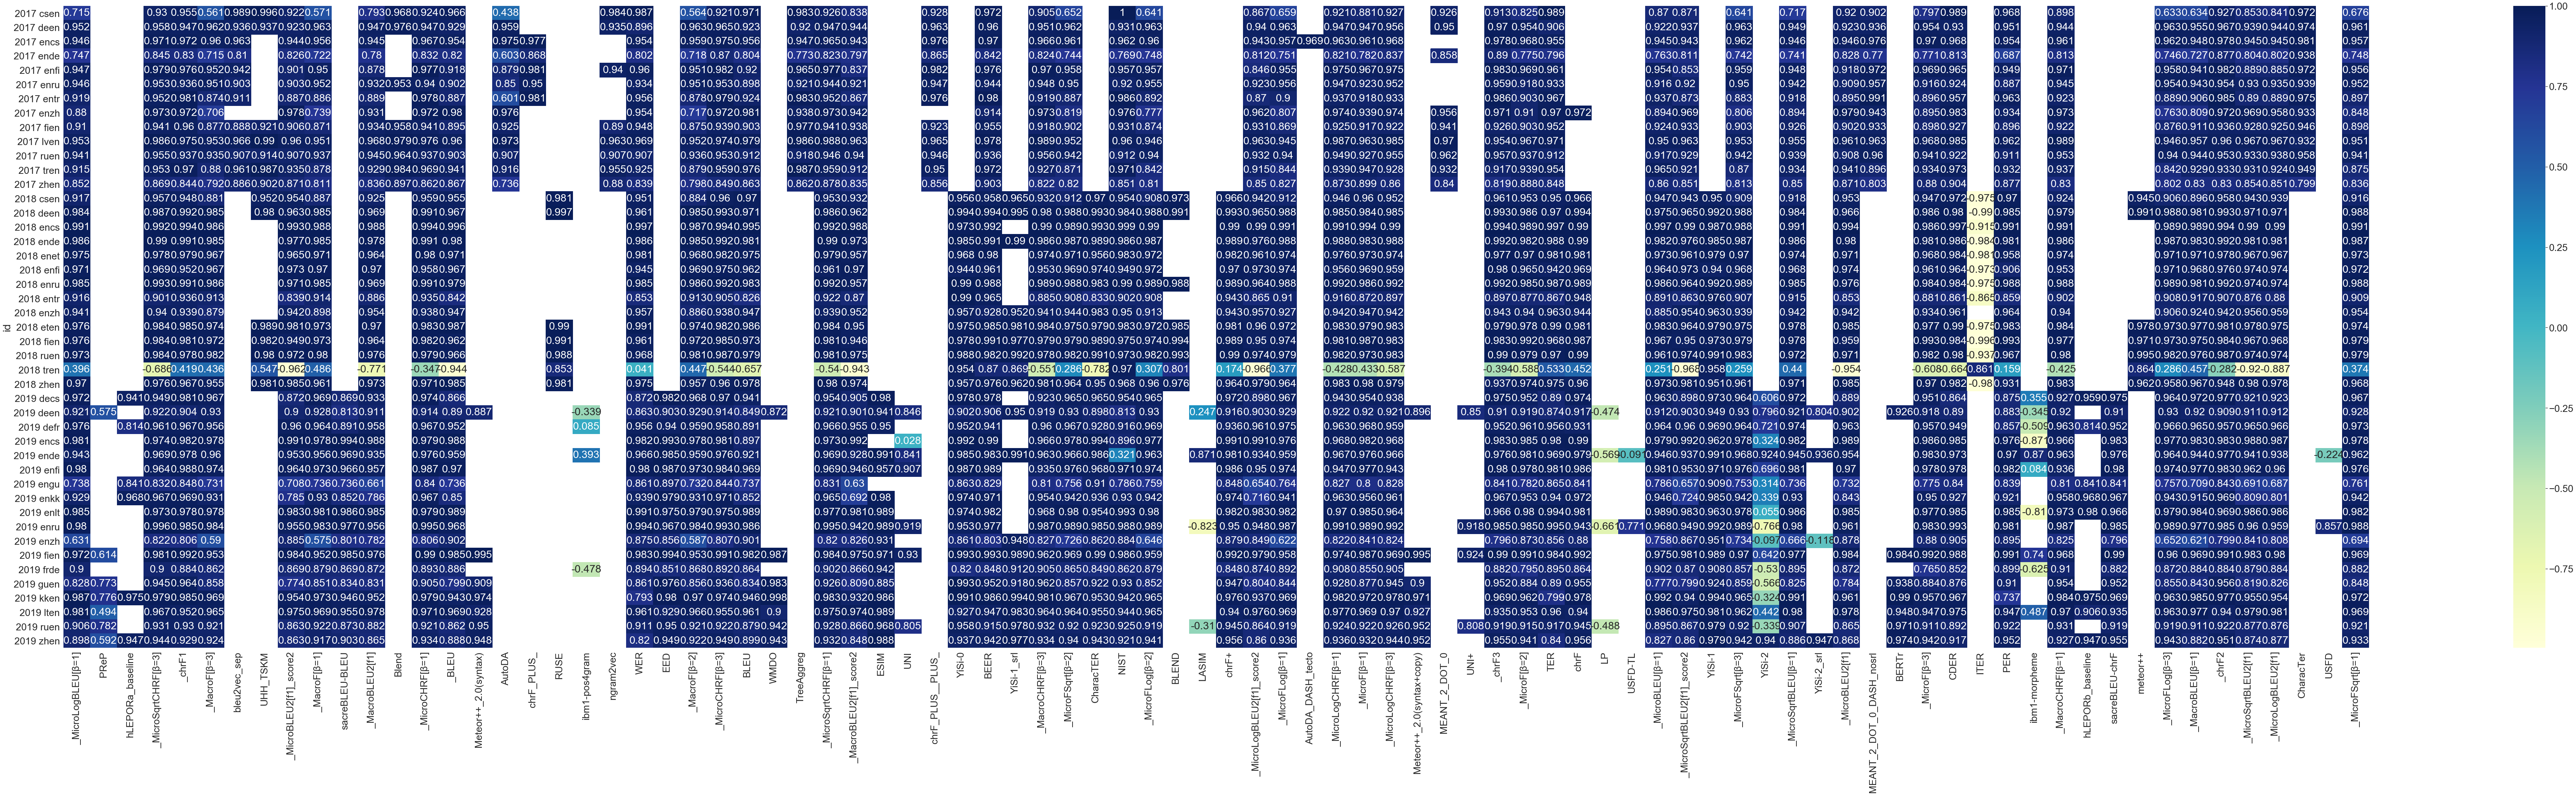

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(font="Times New Roman", style='white',font_scale=2.4)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(140, 32))
    ax = sns.heatmap(p_corr, annot=True, cmap="YlGnBu", fmt='.3g')

In [6]:
# all these have _lc in them
names = [k for k in p_corr.keys() if k + '_lc' in p_corr.keys()] 
print("How much improvement-or-damagae from caseless evaluation?")
print("Name        \tTotal\tMean\tMedian")
for name in names:
    diff = p_corr[name + '_lc'] - p_corr[name]
    print(f'{name:8}\t{diff.sum():.3f}\t{diff.mean():.3f}\t{diff.median():.3f}')

How much improvement-or-damagae from caseless evaluation?
Name        	Total	Mean	Median
bleu    	0.362	0.008	0.002
bleu_eff_order	0.362	0.008	0.002
macro_1gF1	-0.155	-0.003	-0.003
micro_1gF1	1.054	0.023	-0.001
macro_1gF_4gP	0.102	0.002	-0.002
micro_1gF_4gP	0.730	0.016	-0.001


> **Takeaway:  BLEU_lc is better than BLEU; but macro_1gm_F1 is better than its caseless equivalent**



- Get rid off all _lc cols; to reduce number of cols
- Get rid off bleu_eff_order as well; it is same as bleu

In [7]:
names = [k for k in p_corr.keys() if k + '_lc' in p_corr.keys()] 
drop_cols = ['bleu_eff_order'] + [ n + '_lc' for n in names]
p_corr = p_corr.drop(columns=drop_cols)
p_corr

bleu  macro_1gF1  micro_1gF1  macro_1gF_2gP  micro_1gF_2gP  \
id                                                                         
wmt17 cs-en  0.966       0.571       0.881          0.617          0.868   
wmt17 de-en  0.929       0.963       0.947          0.961          0.936   
wmt17 en-cs  0.954       0.956       0.961          0.951          0.954   
wmt17 en-de  0.820       0.722       0.782          0.728          0.775   
wmt17 en-fi  0.918       0.950       0.967          0.944          0.961   
wmt17 en-lv  0.839       0.912       0.939          0.900          0.924   
wmt17 en-ru  0.902       0.952       0.923          0.947          0.915   
wmt17 en-tr  0.887       0.886       0.918          0.902          0.937   
wmt17 en-zh  0.980       0.739       0.939          0.785          0.935   
wmt17 fi-en  0.895       0.871       0.917          0.897          0.909   
wmt17 lv-en  0.960       0.951       0.963          0.958          0.962   
wmt17 ru-en  0.903       0.937       0.927          0.943          0.923   
wmt17 tr-en  0.941       0.878       0.947          0.919          0.967   
wmt17 zh-en  0.867       0.811       0.899          0.830          0.883   
wmt18 cs-en  0.955       0.887       0.960          0.895          0.952   
wmt18 de-en  0.967       0.985       0.984          0.984          0.981   
wmt18 en-cs  0.996       0.988       0.994          0.988          0.995   
wmt18 en-de  0.980       0.985       0.983          0.985          0.984   
wmt18 en-et  0.971       0.971       0.973          0.971          0.974   
wmt18 en-fi  0.967       0.970       0.969          0.969          0.969   
wmt18 en-ru  0.979       0.985       0.986          0.983          0.985   
wmt18 en-tr  0.842       0.914       0.872          0.915          0.882   
wmt18 en-zh  0.947       0.898       0.947          0.917          0.921   
wmt18 et-en  0.987       0.973       0.979          0.976          0.983   
wmt18 fi-en  0.962       0.973       0.987          0.975          0.980   
wmt18 ru-en  0.966       0.980       0.973          0.978          0.965   
wmt18 tr-en -0.944       0.486      -0.433          0.444         -0.260   
wmt18 zh-en  0.985       0.961       0.980          0.966          0.982   
wmt19 de-cs  0.866       0.969       0.954          0.971          0.961   
wmt19 de-en  0.890       0.928       0.920          0.924          0.918   
wmt19 de-fr  0.952       0.964       0.968          0.965          0.970   
wmt19 en-cs  0.988       0.978       0.982          0.981          0.981   
wmt19 en-de  0.959       0.956       0.976          0.950          0.966   
wmt19 en-fi  0.970       0.973       0.977          0.975          0.980   
wmt19 en-gu  0.736       0.736       0.800          0.725          0.804   
wmt19 en-kk  0.850       0.930       0.956          0.922          0.951   
wmt19 en-lt  0.989       0.981       0.985          0.983          0.987   
wmt19 en-ru  0.968       0.983       0.989          0.979          0.981   
wmt19 en-zh  0.902       0.575       0.841          0.603          0.810   
wmt19 fi-en  0.985       0.952       0.987          0.964          0.983   
wmt19 fr-de  0.886       0.879       0.855          0.883          0.876   
wmt19 gu-en  0.799       0.851       0.877          0.848          0.820   
wmt19 kk-en  0.943       0.973       0.972          0.980          0.992   
wmt19 lt-en  0.969       0.969       0.969          0.974          0.981   
wmt19 ru-en  0.862       0.922       0.922          0.917          0.905   
wmt19 zh-en  0.888       0.917       0.932          0.900          0.882   

             macro_1gF_3gP  micro_1gF_3gP  macro_1gF_4gP  micro_1gF_4gP  \
id                                                                        
wmt17 cs-en          0.632          0.869          0.634          0.870   
wmt17 de-en          0.958          0.929          0.955          0.922   
wmt17 en-cs          0.949          0.949          0.948         

In [32]:
pd.DataFrame([p_corr.mean().to_dict(), p_corr.sum().to_dict()], index=['Mean', 'Sum']).round(3)

bleu  macro_1gF1  micro_1gF1  macro_1gF_2gP  micro_1gF_2gP  \
Mean   0.885       0.902       0.911          0.906          0.911   
Sum   40.723      41.491      41.926         41.672         41.890   

      macro_1gF_3gP  micro_1gF_3gP  macro_1gF_4gP  micro_1gF_4gP  \
Mean          0.907          0.911          0.907          0.913   
Sum          41.702         41.924         41.705         42.015   

      macro_1gF_5gP  micro_1gF_5gP  
Mean          0.907          0.913  
Sum          41.702         42.019

Color map values: 
Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

saving to viz/wmt17-pearson.pdf
saving to viz/wmt18-pearson.pdf
saving to viz/wmt19-pearson.pdf


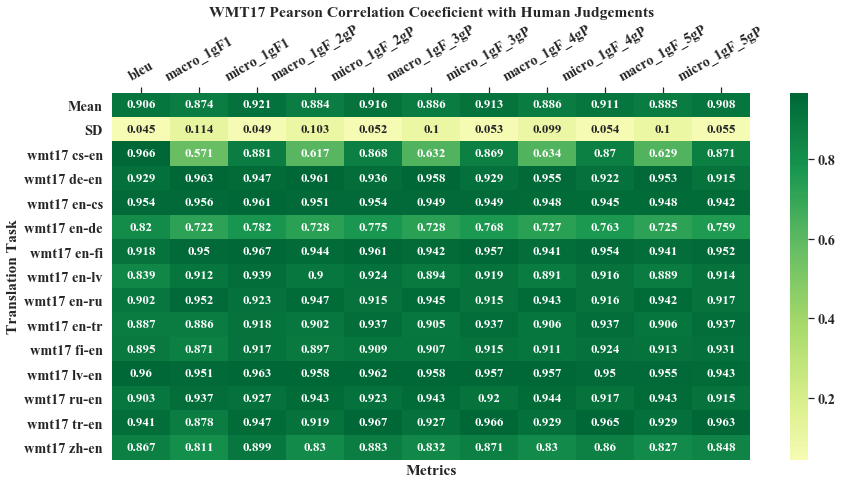

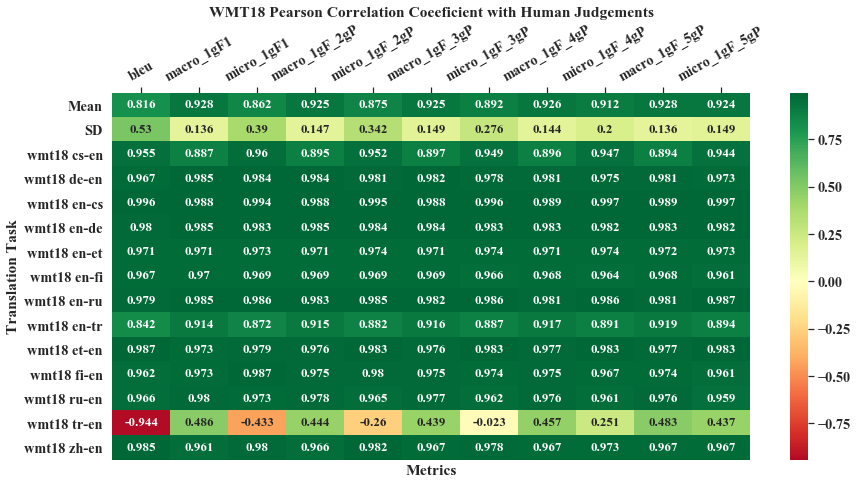

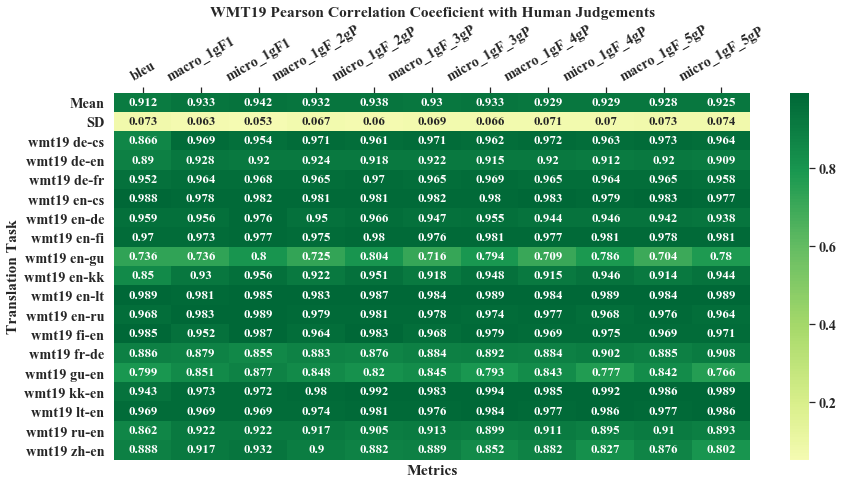

In [56]:
def plot_heatmap(df, figsize=(13, 7), title=None, xlabel='Metrics',
                 ylabel='Translation Task', partition=True,
                 add_sum=False,  add_mean=False, add_sd=False,
                 center=0, fmt='.3g', annot=True, cmap='RdYlGn', saveto=None):

    if partition:
        dfs = []        
        for year in ['wmt17', 'wmt18', 'wmt19']:
            part = df[df.index.to_series().apply(lambda x: year in x)]
            part_saveto = None            
            if saveto:
                basename = year + '-' + saveto.split('/')[-1]
                part_saveto = '/'.join(saveto.split('/')[:-1] + [basename])
            dfs.append((year.upper() + ' ' + title, part_saveto, part))
    else:
        dfs = [title, saveto, df]

    sns.set(font="Times New Roman", style='white',font_scale=1.3, palette=sns.color_palette())
    for title, saveto,  df in dfs:
        
        extra = []
        if add_sum:
            extra.append(['Total', df.sum().to_dict()])
        if add_mean:
            extra.append(['Mean', df.mean().to_dict()])
        if add_sd:
            extra.append(['SD', df.std().to_dict()])
        if extra:
            extra = pd.DataFrame([d for t, d,  in extra], index = [t for t, d in extra]).round(3)
            df = pd.concat([extra, df])

        f, ax = plt.subplots(figsize=figsize)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        annot_kws = {"size": 13}
        g = sns.heatmap(df, annot=annot, fmt=fmt, center=center, cmap=cmap, annot_kws=annot_kws)
        plt.xticks(rotation=30)    
        if title:
            plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.tight_layout()
        if saveto:
            print(f'saving to {saveto}')
            plt.savefig(saveto)

p_corr_no_zh = p_corr[p_corr.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(p_corr_no_zh, title='Pearson Correlation Coeeficient with Human Judgements',
             add_mean=True, add_sd=True, saveto='viz/pearson.pdf')
#'

saving to viz/wmt17-pearson-diff.pdf
saving to viz/wmt18-pearson-diff.pdf
saving to viz/wmt19-pearson-diff.pdf


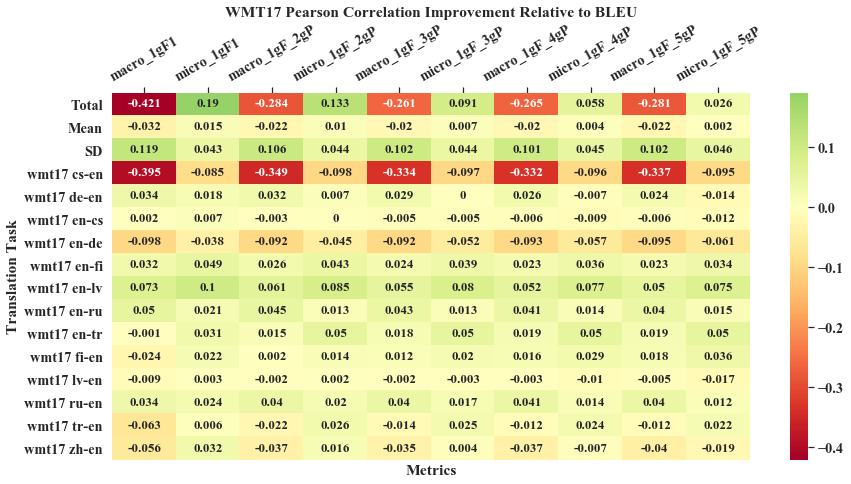

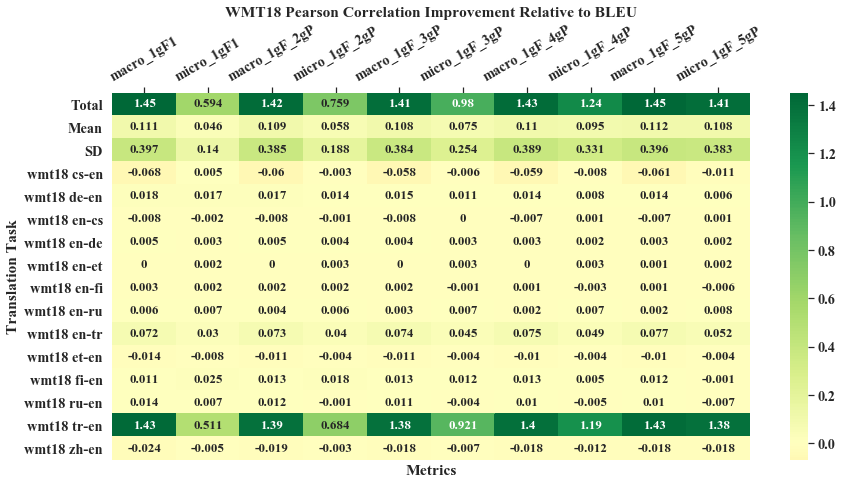

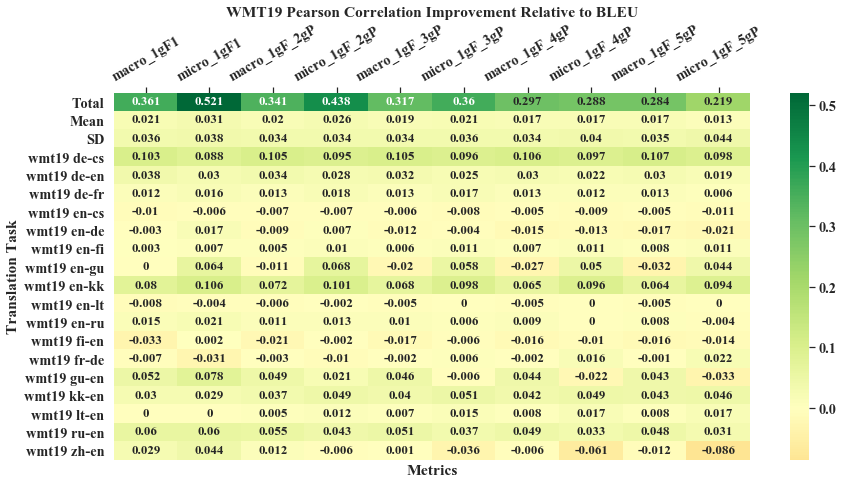

In [57]:
# relative to BLEU

diff = p_corr.copy()
names = [k for k in p_corr.keys() if k != 'bleu']
for name in names:
    diff[name] -= diff['bleu']
diff = diff.drop(columns=['bleu'])


#plot_heatmap(diff, title="Relative Improvement in Pearson Correlation wrt BLEU", 
#             add_mean=True, add_sd=True, add_sum=True)

#chinese is weird!
diff_no_zh = diff[diff.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(diff_no_zh, title="Pearson Correlation Improvement Relative to BLEU",
             add_mean=True, add_sd=True, add_sum=True, saveto='viz/pearson-diff.pdf')

# Spearman

100%|██████████| 46/46 [00:00<00:00, 53.54it/s]


saving to viz/wmt17-spearman.pdf
saving to viz/wmt18-spearman.pdf
saving to viz/wmt19-spearman.pdf
saving to viz/wmt17-spearman-diff.pdf
saving to viz/wmt18-spearman-diff.pdf
saving to viz/wmt19-spearman-diff.pdf


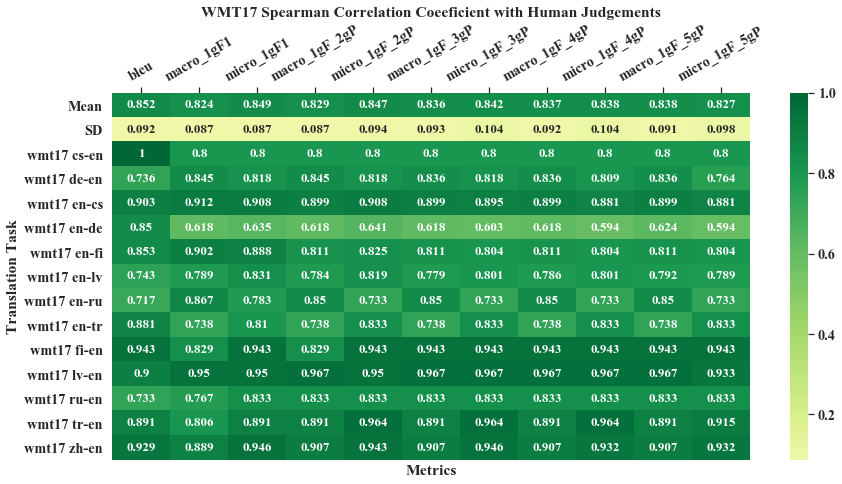

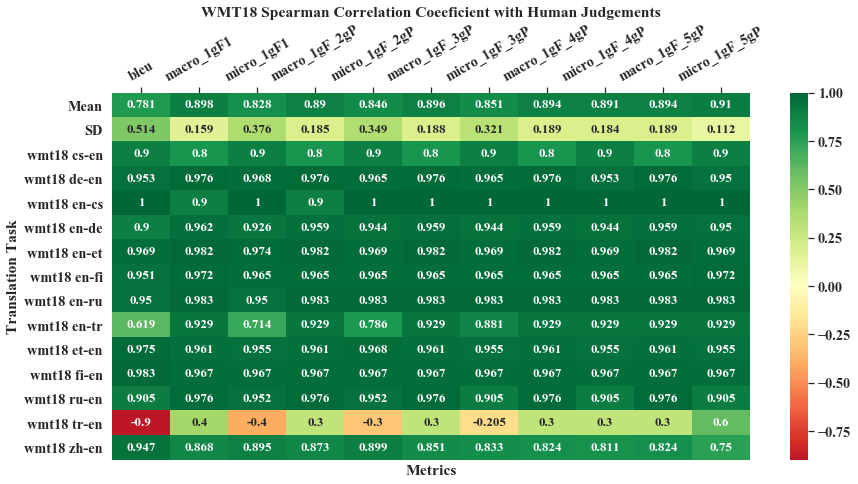

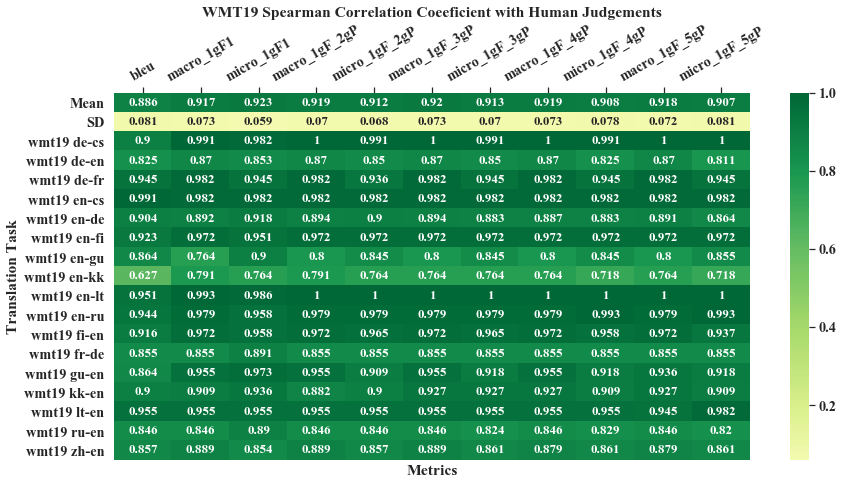

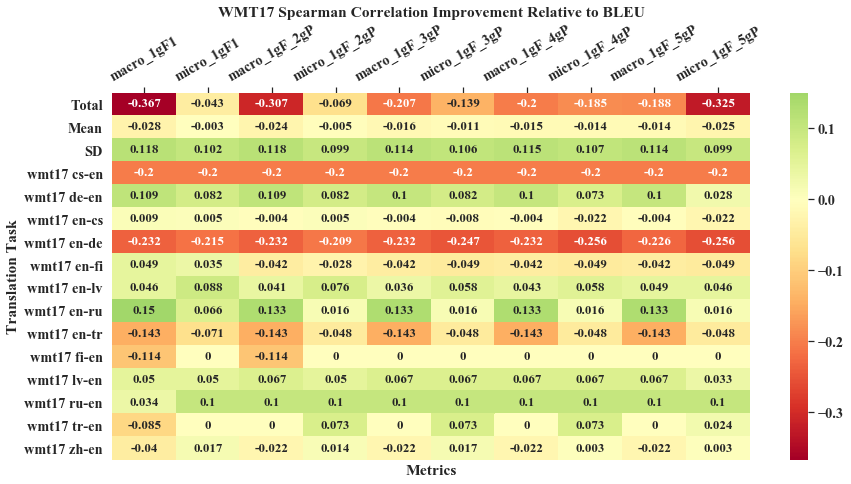

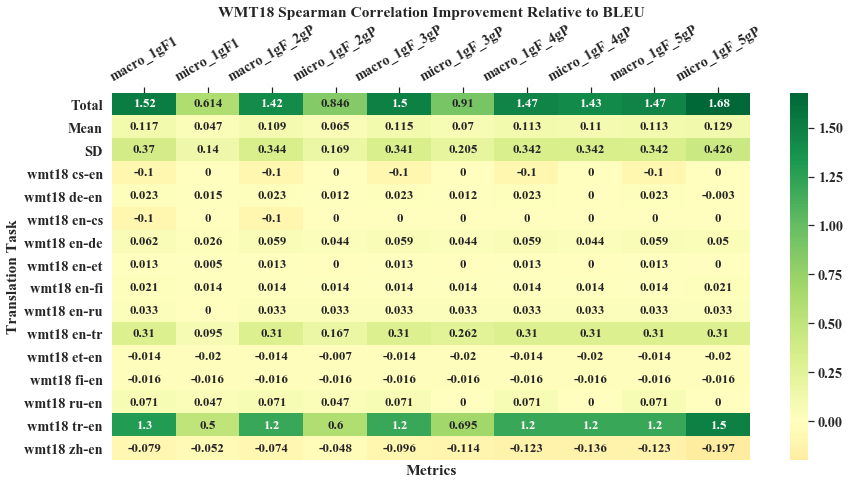

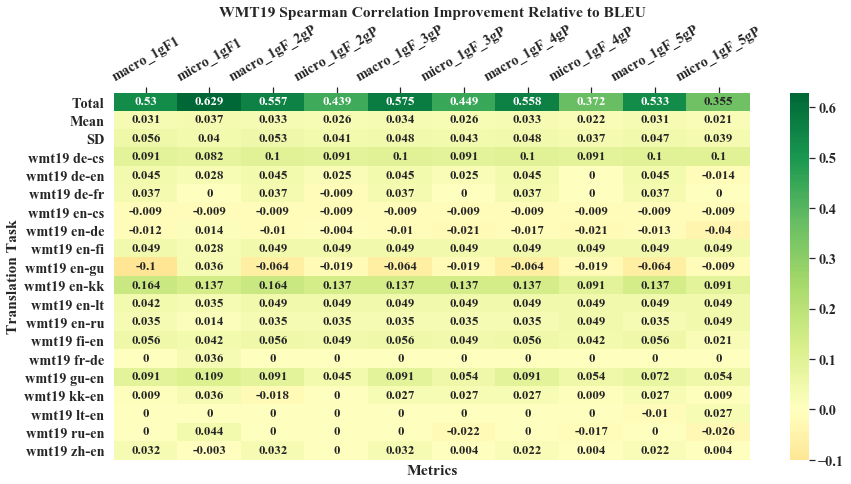

In [60]:
s_corr = correlations(scores, method='spearman')
s_corr['id'] = s_corr['camp'] + ' ' + s_corr['lang']
s_corr = s_corr.set_index(keys=['id'])
s_corr= s_corr.drop(columns=['camp', 'lang', 'n_systs'])

names = [k for k in s_corr.keys() if k + '_lc' in s_corr.keys()] 
drop_cols = ['bleu_eff_order'] + [ n + '_lc' for n in names]
s_corr = s_corr.drop(columns=drop_cols)

s_corr_no_zh = s_corr[s_corr.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(s_corr_no_zh, title='Spearman Correlation Coeeficient with Human Judgements',
            add_mean=True, add_sd=True, saveto='viz/spearman.pdf')

s_diff = s_corr.copy()
names = [k for k in s_corr.keys() if k != 'bleu']
for name in names:
    s_diff[name] -= s_diff['bleu']
s_diff = s_diff.drop(columns=['bleu'])

s_diff_no_zh = s_diff[s_diff.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(s_diff_no_zh, title='Spearman Correlation Improvement Relative to BLEU',
            add_sum=True, add_mean=True, add_sd=True, saveto='viz/spearman-diff.pdf')

---
---

# Visualize BLEU damage


This visualization shows weightage towards low frequency

In [74]:
from typing import List, Set
import re
import collections as coll
from pathlib import Path
import sacrebleu
from sacrebleu import corpus_bleu, TOKENIZERS, corpus_rebleu
from tqdm import tqdm

import logging as log
log.basicConfig(level=log.INFO)

In [65]:
def replace_one_word(word:str, lines: List[str], repl=''):
    assert isinstance(lines, list)
    assert isinstance(word, str)
    res = []
    space_patt = re.compile(r' +')
    for line in lines:
        if word in line:
            line = ' '.join(repl if tok == word else tok for tok in line.split())
            line = space_patt.sub(' ', line).strip()
        res.append(line)
    return res

replace_one_word('the', ['the cat sat on the lazy mat'], repl='')

['cat sat on lazy mat']

In [64]:
!ls wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en

wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en


In [73]:

def read_lines(path):
    with path.open(encoding='utf8', errors='ignore') as f:
        return [line.strip() for line in f]
    
deen_ref = Path('wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en')
tokenizer = TOKENIZERS['13a']

lines = [tokenizer(line.lower()) for line in read_lines(deen_ref)]
log.info(f'{len(lines)} lines in {deen_ref}')
sys = lines
refs = [lines]


def term_frequencies(lines):
    toks = (t for l in lines for t in l.split())
    stats = coll.Counter(toks)
    stats = sorted(stats.items(), reverse=True, key=lambda x: x[1])
    return stats

tfreqs = term_frequencies(lines)
tfreqs[:5], tfreqs[-5:], '\n', len(tfreqs)

INFO:root:2000 lines in wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en


([('the', 3012), ('.', 1902), (',', 1592), ('of', 849), ('in', 827)],
 [('extra-time', 1),
  ('christopher', 1),
  ('nkunku', 1),
  ('groundbreaking', 1),
  ('belgrade', 1)],
 '\n',
 6933)

In [75]:
import multiprocessing as mp
import os
cpu_count = mp.cpu_count()
if 'SLURM_CPUS_ON_NODE' in os.environ:
    cpu_count = int(os.environ['SLURM_CPUS_ON_NODE'])
print('cpus', cpu_count)

def compute_bleu(args):
    word, freq = args
    sys = replace_one_word(word, lines, repl='')
    bleu = corpus_bleu(sys, refs, force=True)
    macro_rebleu = corpus_rebleu(sys, refs, force=True, average='macro', smooth_value=0,  max_order=4)
    micro_rebleu = corpus_rebleu(sys, refs, force=True, average='micro', smooth_value=0, max_order=4)
    return [word, freq, bleu.score, macro_rebleu.score, micro_rebleu.score]

points = []
with mp.Pool(cpu_count) as pool:

    data = tfreqs[-50:]
    n = len(data)    
    for stat in tqdm(pool.imap(compute_bleu, data), total=n):
        points.append(stat)

cpus 2


100%|██████████| 50/50 [05:14<00:00,  6.29s/it]


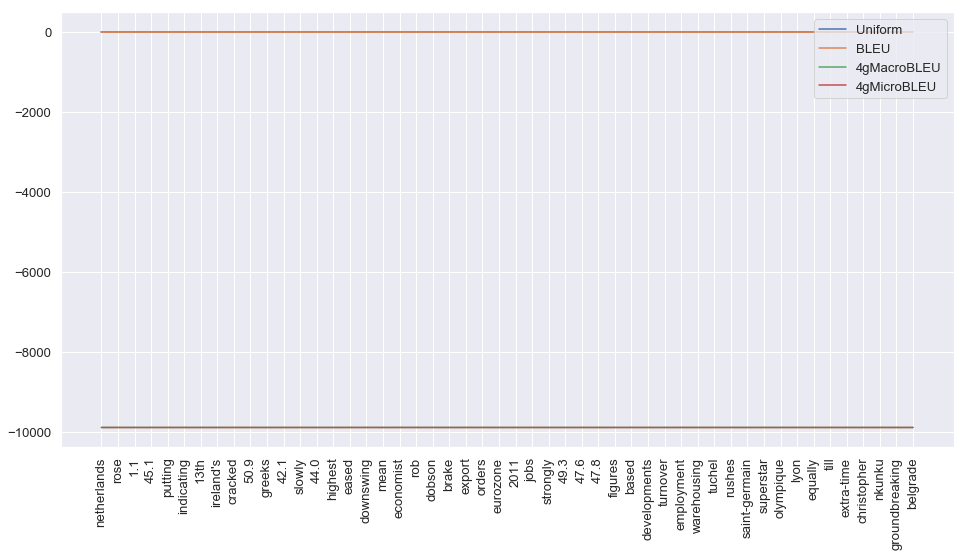

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(x, ys, yscale='log', save=None):
    
    fig = plt.figure(figsize=(16, 8),)
    fig.tight_layout()
    for name, y in ys:
        plt.plot(x, y, label=name)

    plt.xticks(rotation=90) 
    plt.yscale(yscale)
    plt.legend(loc='upper right')
    if save:
        log.info(f'Saving to {save}')
        plt.savefig(save)
    plt.show()
    

pts = points
x = [pt[0] for pt in pts]
uniform = [1/len(tfreqs)] * len(pts)
freqs = [pt[1] for pt in pts]
bleu = [100 - pt[2] for pt in pts]
macro_rebleu = [100 *(1 - pt[3]) for pt in pts]
micro_rebleu = [100 *(1 - pt[4]) for pt in pts]


sns.set(font_scale=1.2)
ys = [
      ('Uniform', uniform),
      ('BLEU', bleu),
      ('4gMacroBLEU', macro_rebleu),
      ('4gMicroBLEU', micro_rebleu)
     ]
# save='bleu-vs-rebleu-viz'
plot_histogram(x, ys, yscale='linear')